# Replication the paper ["An image is worth 16 x 16 Words"](https://www.google.com/search?q=an+image+is+worth+16x16+words&rlz=1C5GCCM_en___IN1163&oq=an+image+i&gs_lcrp=EgZjaHJvbWUqBwgAEAAYgAQyBwgAEAAYgAQyBggBEEUYOTIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIGCAcQRRhA0gEIMjIwNmowajeoAgCwAgA&sourceid=chrome&ie=UTF-8#:~:text=An%20Image%20is%20Worth%2016x16%20Words%3A%20Transformers,https%3A//arxiv.org%20%E2%80%BA%20cs) ViT Paper


### Downloading and preparing the dataset from [Kaggle](https://www.kaggle.com/datasets/balabaskar/tom-and-jerry-image-classification)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/msingh361/.cache/kagglehub/datasets/balabaskar/tom-and-jerry-image-classification/versions/3


In [12]:
import os
import PIL
from pathlib import Path
import matplotlib.pyplot as plt
dataset_path = 'dataset_path/tom_and_jerry/tom_and_jerry/'
for directory,sub_directory,files in os.walk(Path(dataset_path)):
    print(f"The Directory '{directory}' has {len(sub_directory)} sub-directories and {len(files)} files in it.")
print(os.listdir(dataset_path))

The Directory 'dataset_path/tom_and_jerry/tom_and_jerry' has 4 sub-directories and 0 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/tom' has 0 sub-directories and 1930 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/neither_tom_nor_jerry' has 0 sub-directories and 1528 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/jerry' has 0 sub-directories and 1240 files in it.
The Directory 'dataset_path/tom_and_jerry/tom_and_jerry/both_tom_and_jerry' has 0 sub-directories and 780 files in it.
['tom', 'neither_tom_nor_jerry', 'jerry', 'both_tom_and_jerry']


In [33]:
import random
import shutil
train_path = 'dataset_path/tom_and_jerry/train'
test_path = 'dataset_path/tom_and_jerry/test'
subset_directory = 'dataset_path/tom_and_jerry/subset'
# division_percentage = 0.9
for folder in os.listdir(dataset_path):
    print(f"[INFO] working on folder : {folder}")
    total_len = len(os.listdir(dataset_path+'/'+folder))
    train_len = int(0.9 * total_len)
    test_len = int(0.1 * total_len)
    print(f"Total Len : {total_len} \nTrain Len : {train_len} \nTest Len : {test_len}")
    x = random.sample(os.listdir(dataset_path+'/'+folder),train_len)
    print(x)
    print(len(x),len(set(x)))
    os.makedirs(f"{train_path}/{folder}",exist_ok=True)
    os.makedirs(f"{test_path}/{folder}",exist_ok=True)
    os.makedirs(f"{subset_directory}/train/{folder}",exist_ok=True)
    os.makedirs(f"{subset_directory}/test/{folder}",exist_ok=True)
    # moving to train
    print("[INFO] Moving data to Train Folder")
    for images in x:
        shutil.move(f"{dataset_path}/{folder}/{images}",f"{train_path}/{folder}")

    # moving the remaining to test
    print("[INFO] Moving data to Test path")
    for images in os.listdir(dataset_path+'/'+folder):
        shutil.move(f"{dataset_path}/{folder}/{images}",f"{test_path}/{folder}")
    
    #copying to small subset folder for purpose of testing the model at initial phase
    print("creating small sample size for test training")
    
    subset_sample_size = 100
    x = random.sample(os.listdir(f"{train_path}/{folder}"),subset_sample_size)
    for ix in range(len(x)):
        if ix < 90:
            # to train_subset
            shutil.copy(src=f"{train_path}/{folder}/{x[ix]}",dst=f"{subset_directory}/train/{folder}")
        else:
            shutil.copy(src=f"{train_path}/{folder}/{x[ix]}",dst=f"{subset_directory}/test/{folder}")
            # to test_subset

    print("="*30)
    
    

[INFO] working on folder : tom
Total Len : 1930 
Train Len : 1737 
Test Len : 193
['frame322.jpg', 'frame2669.jpg', 'frame5388.jpg', 'frame2112.jpg', 'frame5304.jpg', 'frame3981.jpg', 'frame3815.jpg', 'frame5290.jpg', 'frame4424.jpg', 'frame2947.jpg', 'frame2613.jpg', 'frame4743.jpg', 'frame3737.jpg', 'frame5288.jpg', 'frame4607.jpg', 'frame1273.jpg', 'frame155.jpg', 'frame4528.jpg', 'frame2496.jpg', 'frame5010.jpg', 'frame4909.jpg', 'frame4315.jpg', 'frame1130.jpg', 'frame5069.jpg', 'frame2634.jpg', 'frame5180.jpg', 'frame1774.jpg', 'frame1401.jpg', 'frame4912.jpg', 'frame4759.jpg', 'frame4088.jpg', 'frame4200.jpg', 'frame5454.jpg', 'frame720.jpg', 'frame2604.jpg', 'frame4201.jpg', 'frame2221.jpg', 'frame3404.jpg', 'frame4171.jpg', 'frame2865.jpg', 'frame3244.jpg', 'frame577.jpg', 'frame1974.jpg', 'frame2971.jpg', 'frame4092.jpg', 'frame5213.jpg', 'frame4951.jpg', 'frame4096.jpg', 'frame1943.jpg', 'frame5293.jpg', 'frame2886.jpg', 'frame400.jpg', 'frame1179.jpg', 'frame4274.jpg', 'fra

### Above code is only one time running.

Work will progress for further from below

In [100]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import glob
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import v2

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("✅ Setting Device as CUDA...")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print("🫡 Device is set is MPS...")
    device = torch.device('mps')
else:
    print("No accelerator available 🥺 ...using CPU for this task...")

🫡 Device is set is MPS...


#### Sample dataset preperation

dataset_path/tom_and_jerry/subset/train
tried new:  tom
tom
both_tom_and_jerry
neither_tom_nor_jerry
tom
tom
tom
jerry
both_tom_and_jerry
both_tom_and_jerry


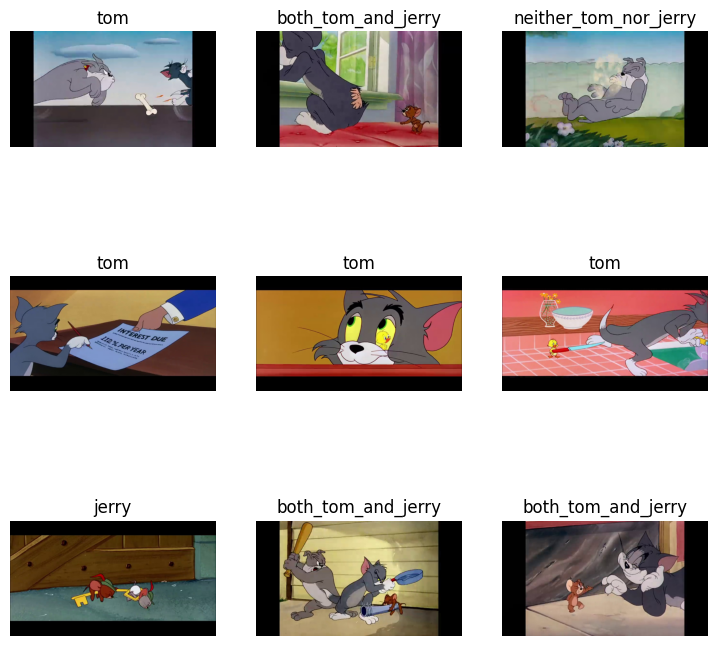

In [182]:

train_subset = subset_directory + '/train'
test_subset = subset_directory + '/test'
print(train_subset)
images_path = glob.glob(train_subset+'/*/*.jpg')
print('tried new: ',Path(images_path[0]).parent.name)
fig = plt.figure(figsize=(9,9))
col = 3
row = 3
images = random.sample(images_path,col*row)

for i in range(1,row*col+1):
    fig.add_subplot(row,col,i)
    plt.imshow(Image.open(images[i-1]))
    name = str(Path(images[i-1]).parent).split('/')[-1]
    print(name)
    plt.title(name)
    plt.axis(False)
    
    



In [203]:

import numpy as np
class TomAndJerryDataset(Dataset):
    def __init__(self,dataset_path,transform=None, target_transform=None):
        super().__init__()
        self.transformation = transform

        self.target_transform = target_transform
        self.classes = os.listdir(dataset_path)
        self.class_to_index = {self.classes[ix]:ix for ix in range(len(self.classes))}
        self.index_to_class = {ix:self.classes[ix] for ix in range(len(self.classes))}
        self.images = glob.glob(dataset_path+'/*/*.jpg')
        self.dataset_path = dataset_path
        self.to_tensor = v2.ToTensor()
        # print(self.images[0])


    def __len__(self,):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.open(image).convert('RGB')
        
        # label = str(Path(self.images[index]).parent).split('/')[-1]
        label = Path(self.images[index]).parent.name
        # print(label)
        # print(np.array(image).shape)
        # plt.imshow(image)

        if self.transformation is not None:
            image = self.transformation(image)
        else:
            image = self.to_tensor(image)

        
        label = self.class_to_index[label]
        if self.target_transform:
            label = self.target_transform(label)
        # plt.imshow(image)
        
        return image,label
    

transform = v2.Compose([
    v2.Resize((224,224)),
    v2.RandomVerticalFlip(p=0.34),
    v2.ToTensor()

])

/Users/msingh361/Uber/Projects/python310_venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [204]:
os.cpu_count()

10

In [205]:
train_dataset = TomAndJerryDataset(train_subset,transform)
test_dataset = TomAndJerryDataset(test_subset)

train_data_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_data_loader = DataLoader(test_dataset,batch_size=32,shuffle=True,num_workers=os.cpu_count())
train_dataset.class_to_index,train_dataset.index_to_class

({'tom': 0, 'neither_tom_nor_jerry': 1, 'jerry': 2, 'both_tom_and_jerry': 3},
 {0: 'tom', 1: 'neither_tom_nor_jerry', 2: 'jerry', 3: 'both_tom_and_jerry'})

In [206]:
len(train_dataset),len(test_dataset)

(360, 40)

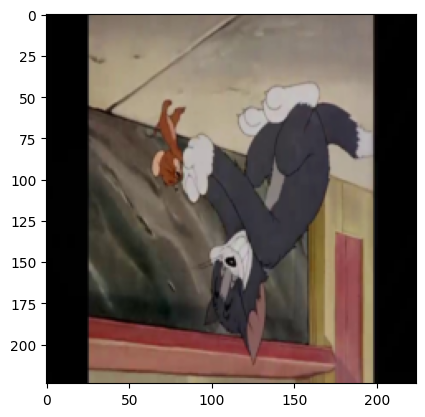

In [211]:
image,label = train_dataset[359]
plt.imshow(image.permute(1,2,0)),label,image.shape
plt.show()


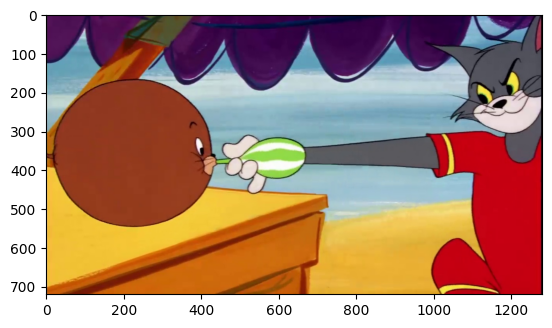

In [212]:
image,label = test_dataset[39]
plt.imshow(image.permute(1,2,0)),label,image.shape
plt.show()